In [43]:
# Install SDP solver and dependencies, slow in first run should be quicker after (a few minutes)

import sys

#%conda install --yes --prefix {sys.prefix} pytest

#%conda install -c conda-forge --yes cvxpy

#%conda install -c conda-forge --yes cvxopt

%pip install pytest
%pip install cvxpy
%pip install cvxopt


You should consider upgrading via the '/Users/noamavidan/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/noamavidan/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/noamavidan/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [44]:
# Import packages
import cvxpy as cp
import numpy as np
import cvxopt
from cvxpy.expressions.expression import Expression


In [45]:
# implament partial trace for Hmin Hmax
def expr_as_np_array(cvx_expr):
    if cvx_expr.is_scalar():
        return np.array(cvx_expr)
    elif len(cvx_expr.shape) == 1:
        return np.array([v for v in cvx_expr])
    else:
        # then cvx_expr is a 2d array
        rows = []
        for i in range(cvx_expr.shape[0]):
            row = [cvx_expr[i,j] for j in range(cvx_expr.shape[1])]
            rows.append(row)
        arr = np.array(rows)
        return arr


def np_array_as_expr(np_arr):
    aslist = np_arr.tolist()
    expr = cp.bmat(aslist)
    return expr


def np_partial_trace(rho, dims, axis=0):
    """
    Takes partial trace over the subsystem defined by 'axis'
    rho: a matrix
    dims: a list containing the dimension of each subsystem
    axis: the index of the subsytem to be traced out
    (We assume that each subsystem is square)
    """
    dims_ = np.array(dims)
    # Reshape the matrix into a tensor with the following shape:
    # [dim_0, dim_1, ..., dim_n, dim_0, dim_1, ..., dim_n]
    # Each subsystem gets one index for its row and another one for its column
    reshaped_rho = np.reshape(rho, np.concatenate((dims_, dims_), axis=None))

    # Move the subsystems to be traced towards the end
    reshaped_rho = np.moveaxis(reshaped_rho, axis, -1)
    reshaped_rho = np.moveaxis(reshaped_rho, len(dims)+axis-1, -1)

    # Trace over the very last row and column indices
    traced_out_rho = np.trace(reshaped_rho, axis1=-2, axis2=-1)

    # traced_out_rho is still in the shape of a tensor
    # Reshape back to a matrix
    dims_untraced = np.delete(dims_, axis)
    rho_dim = np.prod(dims_untraced)
    return traced_out_rho.reshape([rho_dim, rho_dim])


def partial_trace(rho, dims, axis=0):
    if not isinstance(rho, Expression):
        rho = cp.Constant(shape=rho.shape, value=rho)
    rho_np = expr_as_np_array(rho)
    traced_rho = np_partial_trace(rho_np, dims, axis)
    traced_rho = np_array_as_expr(traced_rho)
    return traced_rho



"""
Test out the partial_trace numpy module by creating a matrix
rho_ABC = rho_A \otimes rho_B \otimes rho_C
Each rho_i is normalized, i.e. Tr(rho_i) = 1
"""

# Generate five test cases
rho_A = np.random.rand(4, 4) + 1j*np.random.rand(4, 4)
rho_A /= np.trace(rho_A)
rho_B = np.random.rand(3, 3) + 1j*np.random.rand(3, 3)
rho_B /= np.trace(rho_B)
rho_C = np.random.rand(2, 2) + 1j*np.random.rand(2, 2)
rho_C /= np.trace(rho_C)
rho_AB = np.kron(rho_A, rho_B)
rho_AC = np.kron(rho_A, rho_C)

# Construct a cvxpy Variable with value equal to rho_A \otimes rho_B \otimes rho_C.
temp = np.kron(rho_AB, rho_C)
rho_ABC = cp.Variable(shape=temp.shape, complex=True)
rho_ABC.value = temp

# Try to recover simpler tensors products by taking partial traces of
# more complicated tensors.
rho_AB_test = partial_trace(rho_ABC, [4, 3, 2], axis=2)
rho_AC_test = partial_trace(rho_ABC, [4, 3, 2], axis=1)
rho_A_test = partial_trace(rho_AB_test, [4, 3], axis=1)
rho_B_test = partial_trace(rho_AB_test, [4, 3], axis=0)
rho_C_test = partial_trace(rho_AC_test, [4, 2], axis=0)

# See if the outputs of partial_trace are correct
print("rho_AB test correct? ", np.allclose(rho_AB_test.value, rho_AB))
print("rho_AC test correct? ", np.allclose(rho_AC_test.value, rho_AC))
print("rho_A test correct? ", np.allclose(rho_A_test.value, rho_A))
print("rho_B test correct? ", np.allclose(rho_B_test.value, rho_B))
print("rho_C test correct? ", np.allclose(rho_C_test.value, rho_C))

rho_AB test correct?  True
rho_AC test correct?  True
rho_A test correct?  True
rho_B test correct?  True
rho_C test correct?  True


In [46]:
def Hmin2(A,B):
    """takes rhoA, rhoB numpy arays and returns H_min(A|B)_rho"""
    rhoA = np.asmatrix(A)
    rhoB = np.asmatrix(B)
    if (rhoA.getH() == rhoA).all() & (rhoB.getH() == rhoB).all():
        n = rhoA.shape[0]
        m = rhoB.shape[0]
        IA = np.identity(n)
        IB = np.identity(m)
        A = cp.Parameter((n,n))
        B = cp.Parameter((m,m))
        A.value = rhoA/np.trace(rhoA)
        B.value = rhoB/np.trace(rhoB)

        AB = cp.kron(A,B)/cp.trace(cp.kron(A,B))


        # Calculate exp(-H_min(A|B))
        # Define and solve the CVXPY problem.
        # Create a hermitian matrix variable.
        XB = cp.Variable((m,m),pos=True) 
        # The operator >> denotes matrix inequality.
        constraints = []
        constraints += [cp.kron(IA,XB) >> AB]

        prob = cp.Problem(cp.Minimize(cp.trace(XB)),      
                          constraints)
        prob.solve()
        return(-np.log2(prob.value))
    else:
        print("rhoA and rhoB must be square and of the same dim")

In [47]:
def Hmin(rhoAB,dimA,dimB):
    """takes rhoAB, numpy array and dimA,dimB and returns H_min(A|B)_rho (rhoAB can be non-normal. it is normalized in th function)"""
    if dimA*dimB != rhoAB.shape[0]:
        return("dimA*dimB != shape(rhoAB)")
    if np.any(np.linalg.eigvals(rhoAB) < 0):
        return("rhoAB is not positive semi-definite, min eigenvalue = ",min(np.linalg.eigvals(rhoAB)))
    n = dimA
    m = dimB
    AB = cp.Parameter((n*m,n*m))
    AB.value = rhoAB/np.trace(rhoAB)
    IA = np.identity(n)
    XB = cp.Variable((m,m)) 
    constraints = []
    constraints += [cp.kron(IA,XB) >> AB]
    constraints += [XB >> 0]
    prob = cp.Problem(cp.Minimize(cp.trace(XB)),      
                        constraints)
    prob.solve()
    return(-np.log2(prob.value))

In [48]:
def Hmax(rhoAB,dimA,dimB):
    """takes rhoAB, numpy array and dimA,dimB and returns H_max(A|B)_rho (rhoAB can be sub-normal it is normalized in th function)"""
    if dimA*dimB != rhoAB.shape[0]:
        print("dimA*dimB != shape(rhoAB)")
    if np.any(np.linalg.eigvals(rhoAB) < 0):
        print("rhoAB is not positive semi-definite, min eigenvalue = ",min(np.linalg.eigvals(rhoAB)))
    n = dimA
    m = dimB
    AB = cp.Parameter((n*m,n*m))
    AB.value = rhoAB/np.trace(rhoAB)
    IA = np.identity(n)
    X11 = cp.Variable((n*m,n*m))
    X22 = cp.Variable((n*m,n*m)) 
    X12 = cp.Variable((n*m,n*m))
    X21 = cp.Variable((n*m,n*m))
    SigB = cp.Variable((m,m))     
    I11 = np.array([[1,0],[0,0]])
    I12 = np.array([[0,1],[0,0]])
    I21 = np.array([[0,0],[1,0]])
    I22 = np.array([[0,0],[0,1]])
    XAB = cp.kron(I11,X11)+cp.kron(I22,X22)+cp.kron(I12,X12)+cp.kron(I21,X21)

    constraints = []
    constraints += [X11<<AB]
    constraints += [X22<<cp.kron(IA,SigB)]
    constraints += [cp.trace(SigB)<=1]
    constraints += [XAB>>0]
    constraints += [SigB>>0]
    
    prob = cp.Problem(cp.Maximize(0.5*(cp.trace(X12)+cp.trace(X21))),      
                        constraints)
    prob.solve()
    #print(prob.value,XAB.value)
    return(2*np.log2(prob.value))


In [49]:
rho = np.array([[0,0,0,0]
                ,[0,1,-1,0]
                ,[0,-1,1,0]
                ,[0,0,0,0]])


print("Hmax(rho) =" + str(Hmax(rho,2,2)))
print("Hmin(rho) =" + str(Hmin(rho,2,2)))
print(np.linalg.eigvals(rho))

Hmax(rho) =-0.9993983737991152
Hmin(rho) =-0.9999999996171818
[2. 0. 0. 0.]


# Testing rhoAB's

We want to look at what the projections turn out to be if we let bob measure, get q-c state, 
and then what projections Alice actually does for the binning. 
Look specifically at the pure state pi = |00>-|11>, and on it plus some (diagonal) noise.

In [89]:
def maxmix(d):
    """Returns an np array of a maximally mixed state of schmidt rank 2^d"""
    dim = 2**d
    L = np.zeros(dim**2)
    for i in range(dim):
        keti = np.zeros(dim)
        keti[i] = 1
        ketketi = np.kron(keti,keti)
        L += ketketi
    return(np.outer(L,L))
maxmix(1)

Hmin(maxmix(2),4,4),Hmax(maxmix(1),2,2)

(-1.999999999999929, -0.9994528044164699)

In [121]:
a = 0.99
eps = 10**(-15)
bound = np.zeros([9,9])
for i in range(9):
    bound[i,i] = a
bound[8,8] = bound[6,6] = (1+a)/2
bound[0,8] = bound[8,0] = bound[4,0] = bound[0,4] = bound[8,4] = bound[4,8] = a
bound[6,8] = bound[8,6] = np.sqrt(1-a**2)/2


dimA = dimB = 3
rhoAB = bound + eps*np.identity(9)

rhoAB = rhoAB/(8*a+1)

print("Hmin=",Hmin(rhoAB,dimA,dimB),"Hmax=",Hmax(rhoAB,dimA,dimB),"dif = ", Hmax(rhoAB,dimA,dimB)-Hmin(rhoAB,dimA,dimB),"upper bound of dif is 2log(d_a)=", 2*np.log2(dimA))

print(np.linalg.eigvals(rhoAB))
print(rhoAB.shape)


np.linalg.eigvals(np_partial_trace(rhoAB, [3, 3], axis=1))

Hmin= 0.000605694311629879 Hmax= 1.1476714725547992 dif =  1.1470657782431692 upper bound of dif is 2log(d_a)= 3.169925001442312
[3.33240975e-01 1.11826290e-01 1.11428657e-16 8.83448926e-17
 1.10986547e-01 1.10986547e-01 1.10986547e-01 1.10986547e-01
 1.10986547e-01]
(9, 9)


array([0.33295964, 0.33295964, 0.33408072])

In [116]:
def boundent(alpha):
    a = alpha
    eps = 0.000000000001
    bound = np.zeros([9,9])
    for i in range(9):
        bound[i,i] = a
    bound[8,8] = bound[6,6] = (1+a)/2
    bound[0,8] = bound[8,0] = bound[4,0] = bound[0,4] = bound[8,4] = bound[4,8] = a
    bound[6,8] = bound[8,6] = np.sqrt(1-a**2)/2
    dimA = dimB = 3
    rhoAB = bound + eps*np.identity(9)
    rhoAB = rhoAB/(8*a+1)
    Hminalpha = Hmin(rhoAB,dimA,dimB)
    Hmaxalpha = Hmax(rhoAB,dimA,dimB)
    return(Hminalpha,Hmaxalpha)

n = 1000
X = []
YHmin = []
YHmax = []
for Alpha in range(n):
    X.append(Alpha/n)
    YHmin.append(boundent(Alpha/n)[0])
    YHmax.append(boundent(Alpha/n)[1])
#    print(boundent(Alpha/n)) 


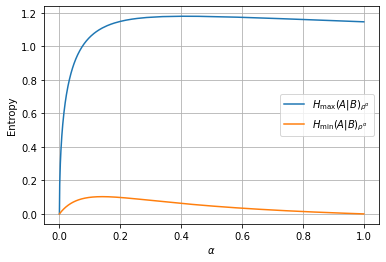

In [127]:
fig, ax = plt.subplots()
ax.plot(X, YHmax,label=r"$H_{\max}(A|B)_{\rho^{\alpha}}$")
ax.plot(X, YHmin,label=r"$H_{\min}(A|B)_{\rho^{\alpha}}$")
ax.legend()
plt.grid()
plt.xlabel(r"$\alpha$")
plt.ylabel("Entropy")
#plt.show()
plt.savefig('/Users/noamavidan/Desktop/newgraph.pdf',dpi=1000,transparent=True)

In [52]:
#defined directly
#example of conditional entropies for a maximally mixed state (|phi> = sum|ii>, rhoAB = |phi><phi|) with error of err
err = 0.015
d = 2
dimA = dimB = 2**d
maxmixd = maxmix(d)/np.trace(maxmix(d))

rhoAB = (1-err)*maxmixd+err*(np.identity(dimB**2)-maxmixd)/np.trace(np.identity(dimB**2)-maxmixd)


print("rhoAB=\n",rhoAB)
dimA = int(np.sqrt(rhoAB.shape[0]))
dimB = int(np.sqrt(rhoAB.shape[0]))
print("Hmin=",Hmin(rhoAB,dimA,dimB),"Hmax=",Hmax(rhoAB,dimA,dimB),"dif = ", Hmax(rhoAB,dimA,dimB)-Hmin(rhoAB,dimA,dimB),"upper bound of dif is 2log(d_a)=", 2*np.log2(dimA))


rhoAB=
 [[0.247 0.    0.    0.    0.    0.246 0.    0.    0.    0.    0.246 0.
  0.    0.    0.    0.246]
 [0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.246 0.    0.    0.    0.    0.247 0.    0.    0.    0.    0.246 0.
  0.    0.    0.    0.246]
 [0.    0.    0.    0.    0.    0.    0.001 0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.
  0.    0.    0.    0.   ]
 [0.246 0.  

In [53]:
d = 4
np.linalg.matrix_rank(np_partial_trace(maxmix(d),[2**d,2**d],axis=0))

16

In [54]:
# Example of a state 
# |phi> = a|00>+b|01>+c|10>+d|11>
# rhoAB = |phi><phi|

ketrho = np.array([1,0,0,1])#,0,1,0,0,0,0,1,0,0,0,0,1])

rhoAB = np.outer(ketrho,ketrho)

rhoAB = rhoAB + np.identity(4)

rhoAB = rhoAB - np.outer(np.array([1,0,0,0]),np.array([1,0,0,0]))-np.outer(np.array([0,0,0,1]),np.array([0,0,0,1]))


#Define Up- a basis transformation
Up = np.array(( [1,1],
                [1,-1]))


#Apply Up transform on A and B
U = np.kron(Up,Up)


#rhoAB = np.matmul(np.linalg.inv(U),np.matmul(rhoAB,U))

#rhoAB = np.kron(rhoAB,rhoAB)

#print("rhoAB=\n",rhoAB/np.trace(rhoAB))
dimA = int(np.sqrt(rhoAB.shape[0]))
dimB = int(np.sqrt(rhoAB.shape[0]))
print("Hmin=",Hmin(rhoAB,dimA,dimB),"Hmax=",Hmax(rhoAB,dimA,dimB),"dif = ", Hmax(rhoAB,dimA,dimB)-Hmin(rhoAB,dimA,dimB),", upper bound of dif is 2log(d_a)=", 2*np.log2(dimA))

Hmin= 6.909790968730433e-13 Hmax= 0.5431991773807522 dif =  0.5431991773800612 , upper bound of dif is 2log(d_a)= 2.0


In [55]:
#post measurement on Bob side


rhoABp = rhoAB


rhoABp[0,1]=rhoABp[0,3]=rhoABp[1,0]=rhoABp[1,2]=0
rhoABp[2,1]=rhoABp[2,3]=rhoABp[3,0]=rhoABp[3,2]=0


print("rhoAB=\n",rhoABp/np.trace(rhoABp))
dimA = int(np.sqrt(rhoABp.shape[0]))
dimB = int(np.sqrt(rhoABp.shape[0]))
print("Hmin=",Hmin(rhoABp,dimA,dimB),"Hmax=",Hmax(rhoABp,dimA,dimB),"dif = ", Hmax(rhoABp,dimA,dimB)-Hmin(rhoABp,dimA,dimB),", upper bound of dif is 2log(d_a)=", 2*np.log2(dimA))

np.linalg.eigvals(rhoABp)

rhoAB=
 [[0.25 0.   0.   0.  ]
 [0.   0.25 0.   0.  ]
 [0.   0.   0.25 0.  ]
 [0.   0.   0.   0.25]]
Hmin= 1.0000000000000078 Hmax= 0.9999999946449218 dif =  -5.355085930247583e-09 , upper bound of dif is 2log(d_a)= 2.0


array([1., 1., 1., 1.])

In [56]:
#looking at the subsystems and at the ratio of the eigenvalues
# example of a state with low igenvalue ratios maxA/minA maxB/minB but high maxAB/minAB, 
# so limiting the eigenvalues of the subsistems + LOCC is not eneugh to limit eigenvalues of the bipartite system.
#rhoAB = np.array(([1,1,1,0],
#                  [1,1600,0,1],
#                  [1,0,1600,1],
#                  [0,1,1,1]))

n = int(np.sqrt(rhoAB.shape[0]))
AB = cp.Parameter((n**2,n**2))
AB.value = rhoAB
rhoA = partial_trace(AB,[n,n],axis=1)
rhoA = np.asmatrix(rhoA.value)
rhoB = partial_trace(AB,[n,n],axis=0)
rhoB = np.asmatrix(rhoB.value)
nonzeroiegensAB = [np.linalg.eigvals(rhoAB)[i] for i in range(len(np.linalg.eigvals(rhoAB))) if np.linalg.eigvals(rhoAB)[i] > 0.001]
nonzeroiegensA = [np.linalg.eigvals(rhoA)[i] for i in range(len(np.linalg.eigvals(rhoA))) if np.linalg.eigvals(rhoA)[i] > 0.001]
nonzeroiegensB = [np.linalg.eigvals(rhoB)[i] for i in range(len(np.linalg.eigvals(rhoB))) if np.linalg.eigvals(rhoB)[i] > 0.001]

print("maxA/minA =", max(nonzeroiegensA)/min(nonzeroiegensA))
print("maxB/minB =", max(nonzeroiegensB)/min(nonzeroiegensB))
print("maxAB/minAB =", max(nonzeroiegensAB)/min(nonzeroiegensAB))
print("(maxA/minA)*(maxB/minB)= ", (max(nonzeroiegensB)/min(nonzeroiegensB))*max(nonzeroiegensA)/min(nonzeroiegensA))
print("rhoA=\n", rhoA,"\n" ,"rhoB=\n",rhoB)

print("eigenvalues of rhoA=\n",np.linalg.eigvals(rhoA), "\n eigenvalues of rhoB=\n" ,np.linalg.eigvals(rhoB),"\n eigenvalues of rhoAB=\n", np.linalg.eigvals(rhoAB))

print(np.trace(rhoAB))
rhoC = np.kron(rhoA,rhoB)
print("rhoA(tnsor)rhoB=\n",rhoC)

maxA/minA = 1.0
maxB/minB = 1.0
maxAB/minAB = 1.0
(maxA/minA)*(maxB/minB)=  1.0
rhoA=
 [[2. 0.]
 [0. 2.]] 
 rhoB=
 [[2. 0.]
 [0. 2.]]
eigenvalues of rhoA=
 [2. 2.] 
 eigenvalues of rhoB=
 [2. 2.] 
 eigenvalues of rhoAB=
 [1. 1. 1. 1.]
4.0
rhoA(tnsor)rhoB=
 [[4. 0. 0. 0.]
 [0. 4. 0. 0.]
 [0. 0. 4. 0.]
 [0. 0. 0. 4.]]


## Now I tryed to calculate max_rhoB Hmin(A|B)_rho and min_rhoB Hmax(A|B)_rhoB to see if the difference can be bounded with limitations only on rhoA and rank rho_B (seems like this is not possible, maxHmin can be very big even if B is a small state)

In [57]:
def Hmin_maxoverB(rhoA,dimB):
    """takes rhoA, rank(rhoB) numpy aray and int and returns max_rhoB H_min(A|B)_rho"""
    if (np.asmatrix(rhoA).getH() == np.asmatrix(rhoA)).all():
        n = rhoA.shape[0]
        m = dimB
        IA = np.identity(n)
        IB = np.identity(m)
        A = cp.Parameter((n,n))
        B = cp.Variable((m,m),PSD = True)
        A.value = rhoA/np.trace(rhoA)
        #B.value = rhoB/np.trace(rhoB)

        #AB = cp.Variable((m*n,m*n))
        AB = cp.kron(A,B)#/cp.trace(cp.kron(A,B))


        # Calculte exp(-H_min(A|B))
        # Define and solve the CVXPY problem.
        # Create a hermitian matrix variable.
        XB = cp.Variable((m,m),pos=True) 
        # The operator >> denotes matrix inequality.


        constraints = []
        constraints += [cp.kron(IA,XB) >> AB] # cp.kron(A,B)*(1/cp.trace(cp.kron(A,B)))] #I*X >= rho_{AB} = A*B
        constraints += [cp.trace(AB)<=1]
        constraints += [cp.trace(B)<=1]
        #constraints += [B<<0.0005*IB]
        #constraints += [B>>0.25*IB]

        prob = cp.Problem(cp.Minimize(cp.trace(XB)),      
                          constraints)
        prob.solve()
        print("B=",B.value)
        print(prob.value)
        return(-np.log2(prob.value))
    else:
        print("rhoA and rhoB must be squere and of the same dim")

In [58]:
A = np.array([[1,2],
              [2,4]])
B = np.array([[1,0],
              [0,4]])

rAB = np.kron(A,B)

print("rhoABp=\n",rAB)
dimA = int(np.sqrt(rAB.shape[0]))
dimB = int(np.sqrt(rAB.shape[0]))
print("Hmin=",Hmin(rAB,dimA,dimB),"Hmax=",Hmax(rAB,dimA,dimB),"dif = ", Hmax(rAB,dimA,dimB)-Hmin(rAB,dimA,dimB),"upper bound of dif is 2log(d_a)=", 2*np.log2(dimA))


rhoABp=
 [[ 1  0  2  0]
 [ 0  4  0  8]
 [ 2  0  4  0]
 [ 0  8  0 16]]
Hmin= 1.1449046324639059e-12 Hmax= 0.00021216670543102313 dif =  0.0002121667042861185 upper bound of dif is 2log(d_a)= 2.0


In [59]:
alpha = (3+1j)/(4*np.sqrt(2))
beta = (np.sqrt(3)+np.sqrt(3)*1j)/(4*np.sqrt(2))
gamma = (-1-3j)/(4*np.sqrt(2))



B =       np.array(([alpha*np.conjugate(alpha),beta*np.conjugate(alpha),0,0],
                    [alpha*np.conjugate(beta),beta*np.conjugate(beta),0,0],
                    [0,0,beta*np.conjugate(beta),beta*np.conjugate(gamma)],
                    [0,0,gamma*np.conjugate(beta),gamma*np.conjugate(gamma)]))

np.linalg.eigvals(B)

array([5.00000000e-01-1.19227256e-17j, 3.89394586e-17-1.95506225e-18j,
       5.09902483e-17-1.71268960e-17j, 5.00000000e-01-1.06286796e-17j])

In [60]:
alpha = (3+1j)/(4*np.sqrt(2))
beta = (np.sqrt(3)+np.sqrt(3)*1j)/(4*np.sqrt(2))
gamma = (-1-3j)/(4*np.sqrt(2))




alpha*np.conjugate(alpha)+2*beta*np.conjugate(beta)+gamma*np.conjugate(gamma)

(0.9999999999999998+0j)

In [61]:

# cheking if H_dounarrow makes sense for Hmin at least on Bell states 
# yes

ketrho = np.array([1,0,0,1])

rhoAB = np.outer(ketrho,ketrho)

rhoAB = rhoAB + 0.25*np.identity(4)

rhoAB = rhoAB/np.trace(rhoAB)

print("rhoAB =\n", rhoAB)
rhoB = np_partial_trace(rhoAB,[2,2])
rhoB = rhoB/np.trace(rhoB)
print("rhoB = \n",rhoB)
IrhoB = np.kron(np.identity(2),rhoB)
Irhob = IrhoB/np.trace(IrhoB)
#largest gamma that works is -1 as expected from Hmin on bell state
gamma = -1   

rhopo = 2**(-gamma)*IrhoB-rhoAB



print("I(*)rhoB = \n",IrhoB)

print(np.linalg.eigvals(rhopo))



#np.linalg.eigvals(rhopo)>0


rhoAB =
 [[0.41666667 0.         0.         0.33333333]
 [0.         0.08333333 0.         0.        ]
 [0.         0.         0.08333333 0.        ]
 [0.33333333 0.         0.         0.41666667]]
rhoB = 
 [[0.5 0. ]
 [0.  0.5]]
I(*)rhoB = 
 [[0.5 0.  0.  0. ]
 [0.  0.5 0.  0. ]
 [0.  0.  0.5 0. ]
 [0.  0.  0.  0.5]]
[0.91666667 0.25       0.91666667 0.91666667]


In [62]:
np.log2(3/2)

0.5849625007211562

In [63]:
# a function to calculate H_min^dounarrow(A|B)
# unoptimized min entropy (and the function is also not very efficient)

def Hminmin(rhoAB,dimA,dimB):
    RAB = rhoAB/np.trace(rhoAB)
    n = dimA
    m = dimB
    RB = np_partial_trace(RAB,[n,m])
    RB = RB/np.trace(RB)
    IrhoB = np.kron(np.identity(n),RB)
    Irhob = IrhoB/np.trace(IrhoB)
    L = [gamma/1000 - 20 for gamma in range(200001)]
    H = []
    for gamma in L:
        rhopo = (2**(-gamma))*IrhoB-RAB
        if (np.linalg.eigvals(rhopo)>=0).all():
            H = H + [gamma]
    return(max(H))



In [64]:
# looking for counter example:
n = 2
m = 2
ketrho1 = np.array([1,0,0,1])

rho1 = np.outer(ketrho1,ketrho1)

ketrho2 = np.array([0,1,0,0])

rho2 = np.outer(ketrho2,ketrho2)

ketrho3 = np.array([0,0,1,0])

rho3 = np.outer(ketrho3,ketrho3)

ketrho4 = np.array([0,0,0,0])

rho4 = np.outer(ketrho4,ketrho4)



rhoAB = rho1+rho2+rho3+rho4


#rhoAB = rhoAB + np.identity(n*n)

rhoAB = rhoAB/np.trace(rhoAB)

print("Hmindown(A|B)=",Hminmin(rhoAB,n,m))

Hmindown(A|B)= 0.0


In [65]:
p = 0.5
T = np.array([ [1-p,0,0,0],
                [0,1+p,-2*p,0],
                [0,-2*p,1+p,0],
                [0,0,0,1-p]])
T = T/np.trace(T)
print("Hmindown(A|B)_T=",Hminmin(T,2,2))
print(np.linalg.eig(T))

Hmindown(A|B)_T= -0.3219999999999992
(array([0.625, 0.125, 0.125, 0.125]), array([[ 0.        ,  0.        ,  1.        ,  0.        ],
       [-0.70710678,  0.70710678,  0.        ,  0.        ],
       [ 0.70710678,  0.70710678,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]))


In [66]:
rhoB = np_partial_trace(rhoAB,[n,m],axis=0)
rhoA = np_partial_trace(rhoAB,[n,m],axis=1)
rhoA = rhoA/np.trace(rhoA)
print("rhoA = \n",rhoA,"\n rhoB = \n",rhoB)
rhoB = rhoB/np.trace(rhoB)
IrhoB = np.kron(np.identity(n),rhoB)
Irhob = IrhoB/np.trace(IrhoB)

ExpH = np.trace(np.matmul(rho1/2,IrhoB)+np.matmul(rho2,IrhoB)+np.matmul(rho3,IrhoB)+np.matmul(rho4,IrhoB))


print("H0 >=",np.log2(ExpH))

rhoA = 
 [[0.5 0. ]
 [0.  0.5]] 
 rhoB = 
 [[0.5 0. ]
 [0.  0.5]]
H0 >= 0.5849625007211562


In [67]:
# H0 for Werner states?
# need to write in form of projections:

n = m = 2
p = 0
T = np.array([ [1-p,0,0,0],
                [0,1+p,-2*p,0],
                [0,-2*p,1+p,0],
                [0,0,0,1-p]])
TAB = T/np.trace(T)
TB = np_partial_trace(TAB,[n,m],axis=0)
TA = np_partial_trace(TAB,[n,m],axis=1)
TA = TA/np.trace(TA)
print("rhoA = \n",TA,"\n rhoB = \n",TA)
TB = TB/np.trace(TB)
ITB = np.kron(np.identity(n),TB)
ITB = ITB/np.trace(ITB)




print("H0 >=",np.log2(np.trace(ITB)))

rhoA = 
 [[0.5 0. ]
 [0.  0.5]] 
 rhoB = 
 [[0.5 0. ]
 [0.  0.5]]
H0 >= 0.0


In [68]:



n = 3
m = 2
ketrho1 = np.sqrt(2)*np.array([1,0,0,0,0,1])#,0,2,0,0,0,0,1,0,0,0,0,1])

rho1 = np.outer(ketrho1,ketrho1)

ketrho2 = np.array([0,1,1,0,0,0])

rho2 = np.outer(ketrho2,ketrho2)

ketrho3 = np.array([0,1,1,0,0,0])

rho3 = np.outer(ketrho3,ketrho3)

ketrho4 = np.array([0,0,0,1,1,0])

rho4 = np.outer(ketrho4,ketrho4)

ketrho5 = np.array([0,0,0,1,1,0])

rho5 = np.outer(ketrho5,ketrho5)



rhoAB = rho1+rho2+rho3+rho4+rho5

#rhoAB = rhoAB + np.identity(n*n)

rhoAB = rhoAB/np.trace(rhoAB)

print("Hmindown(A|B)=",Hminmin(rhoAB,n,m))

Hmindown(A|B)= 0.5839999999999996


In [69]:
rhoB = np_partial_trace(rhoAB,[n,m],axis=0)
rhoA = np_partial_trace(rhoAB,[n,m],axis=1)
rhoA = rhoA/np.trace(rhoA)
print("rhoA = \n",rhoA,"\n rhoB = \n",rhoB)
rhoB = rhoB/np.trace(rhoB)
IrhoB = np.kron(np.identity(n),rhoB)
Irhob = IrhoB/np.trace(IrhoB)

ExpH = np.trace(np.matmul(rho1/(2*np.sqrt(2)),IrhoB)+np.matmul(rho2/2,IrhoB)+np.matmul(rho3/2,IrhoB)+np.matmul(rho4/2,IrhoB)+np.matmul(rho5/2,IrhoB))

print("H0 >",np.log2(ExpH))


rhoA = 
 [[0.33333333 0.         0.        ]
 [0.         0.33333333 0.        ]
 [0.         0.         0.33333333]] 
 rhoB = 
 [[0.5 0. ]
 [0.  0.5]]
H0 > 1.4367517954398241


In [70]:
np.log2(0.3333)

-1.5851067774392014

In [71]:
#Checking if H0downarrow makes sense:
n = 2
m = 2
rhoB = np_partial_trace(rhoAB,[n,m],axis=0)
rhoA = np_partial_trace(rhoAB,[n,m],axis=1)
rhoA = rhoA/np.trace(rhoA)
print("rhoA = \n",rhoA,"\n rhoB = \n",rhoB)
rhoB = rhoB/np.trace(rhoB)
IrhoB = np.kron(np.identity(n),rhoB)
Irhob = IrhoB/np.trace(IrhoB)
print("IrhoB = \n", IrhoB)
rhop = np.matmul(rhoAB,IrhoB)
print("rhoAB*IrhoB = \n",rhop)
print("H0(A|B) = ",np.log2(np.trace(T)))
print(np.linalg.eigvals(rhoAB))

ValueError: cannot reshape array of size 36 into shape (2,2,2,2)

2.807354922057604

In [ ]:
np.matmul(rhoAB,rhoAB),rhoAB

In [ ]:
# implament partial trace for min Hmax
def expr_as_np_array(cvx_expr):
    if cvx_expr.is_scalar():
        return np.array(cvx_expr)
    elif len(cvx_expr.shape) == 1:
        return np.array([v for v in cvx_expr])
    else:
        # then cvx_expr is a 2d array
        rows = []
        for i in range(cvx_expr.shape[0]):
            row = [cvx_expr[i,j] for j in range(cvx_expr.shape[1])]
            rows.append(row)
        arr = np.array(rows)
        return arr


def np_array_as_expr(np_arr):
    aslist = np_arr.tolist()
    expr = cp.bmat(aslist)
    return expr


def np_partial_trace(rho, dims, axis=0):
    """
    Takes partial trace over the subsystem defined by 'axis'
    rho: a matrix
    dims: a list containing the dimension of each subsystem
    axis: the index of the subsytem to be traced out
    (We assume that each subsystem is square)
    """
    dims_ = np.array(dims)
    # Reshape the matrix into a tensor with the following shape:
    # [dim_0, dim_1, ..., dim_n, dim_0, dim_1, ..., dim_n]
    # Each subsystem gets one index for its row and another one for its column
    reshaped_rho = np.reshape(rho, np.concatenate((dims_, dims_), axis=None))

    # Move the subsystems to be traced towards the end
    reshaped_rho = np.moveaxis(reshaped_rho, axis, -1)
    reshaped_rho = np.moveaxis(reshaped_rho, len(dims)+axis-1, -1)

    # Trace over the very last row and column indices
    traced_out_rho = np.trace(reshaped_rho, axis1=-2, axis2=-1)

    # traced_out_rho is still in the shape of a tensor
    # Reshape back to a matrix
    dims_untraced = np.delete(dims_, axis)
    rho_dim = np.prod(dims_untraced)
    return traced_out_rho.reshape([rho_dim, rho_dim])


def partial_trace(rho, dims, axis=0):
    if not isinstance(rho, Expression):
        rho = cp.Constant(shape=rho.shape, value=rho)
    rho_np = expr_as_np_array(rho)
    traced_rho = np_partial_trace(rho_np, dims, axis)
    traced_rho = np_array_as_expr(traced_rho)
    return traced_rho



"""
Test out the partial_trace numpy module by creating a matrix
rho_ABC = rho_A \otimes rho_B \otimes rho_C
Each rho_i is normalized, i.e. Tr(rho_i) = 1
"""

# Generate five test cases
rho_A = np.random.rand(4, 4) + 1j*np.random.rand(4, 4)
rho_A /= np.trace(rho_A)
rho_B = np.random.rand(3, 3) + 1j*np.random.rand(3, 3)
rho_B /= np.trace(rho_B)
rho_C = np.random.rand(2, 2) + 1j*np.random.rand(2, 2)
rho_C /= np.trace(rho_C)
rho_AB = np.kron(rho_A, rho_B)
rho_AC = np.kron(rho_A, rho_C)

# Construct a cvxpy Variable with value equal to rho_A \otimes rho_B \otimes rho_C.
temp = np.kron(rho_AB, rho_C)
rho_ABC = cp.Variable(shape=temp.shape, complex=True)
rho_ABC.value = temp

# Try to recover simpler tensors products by taking partial traces of
# more complicated tensors.
rho_AB_test = partial_trace(rho_ABC, [4, 3, 2], axis=2)
rho_AC_test = partial_trace(rho_ABC, [4, 3, 2], axis=1)
rho_A_test = partial_trace(rho_AB_test, [4, 3], axis=1)
rho_B_test = partial_trace(rho_AB_test, [4, 3], axis=0)
rho_C_test = partial_trace(rho_AC_test, [4, 2], axis=0)

# See if the outputs of partial_trace are correct
print("rho_AB test correct? ", np.allclose(rho_AB_test.value, rho_AB))
print("rho_AC test correct? ", np.allclose(rho_AC_test.value, rho_AC))
print("rho_A test correct? ", np.allclose(rho_A_test.value, rho_A))
print("rho_B test correct? ", np.allclose(rho_B_test.value, rho_B))
print("rho_C test correct? ", np.allclose(rho_C_test.value, rho_C))


rho_AB test correct?  True
rho_AC test correct?  True
rho_A test correct?  True
rho_B test correct?  True
rho_C test correct?  True


Variable((24, 24), complex=True)

In [ ]:
# Hmax(A|B) primal

def Hmax_minB(rhoA, dimB):
    n = rhoA.shape[0]
    m = dimB
    A = cp.Parameter((n,n))
    A.value = rhoA
    B = cp.Variable((m,m))
    AB = cp.kron(A,B)#/cp.trace(cp.kron(A,B))
    Y11 = cp.Variable((n*m,n*m),pos=True)
    Y22 = cp.Variable((n*m,n*m),pos=True) 
    Y12 = cp.Variable((n*m,n*m))
    Y21 = cp.Variable((n*m,n*m)) 
    I = np.identity(n)

    I11 = np.matrix([[1,0],[0,0]])
    I12 = np.matrix([[0,1],[0,0]])
    I21 = np.matrix([[0,0],[1,0]])
    I22 = np.matrix([[0,0],[0,1]])
    YAB = cp.kron(I11,Y11)+cp.kron(I22,Y22)+cp.kron(I12,Y12)+cp.kron(I21,Y21)
    II = np.identity(n*m)

    constraints = []
    constraints += [cp.kron(I11,Y11)+cp.kron(I22,Y22) >> 0.5*(cp.kron(I12,II)+cp.kron(I21,II))] 
    constraints += [gamma >= 0] 
    constraints += [cp.trace(AB) <= 1] 
    constraints += [gamma*I >> partial_trace(Y22,[n,m],axis = 1)] #should be gamma*I_B >> partial_trace_{A}(Y22)
    prob = cp.Problem(cp.Minimize(cp.trace(AB*(Y11))+gamma),      
                    constraints)
    prob.solve()
    return(2*np.log2(prob.value))


In [ ]:
rb = np.array([ [1,0],
                [0,2]])

np.kron(np.identity(2),rb)